## Applying the XGBoost algorithm ##

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import pandas as pd
import numpy as np

# from keras.wrappers.scikit_learn import KerasRegressor
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import KFold
# from sklearn.preprocessing import StandardScaler # needed?
import xgboost as xgb
import holidays

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
# from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# for reading files
import glob
import os
from datetime import datetime
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

In [40]:
# input dataset
input_file = "./drive/My Drive/remote_communities/data/all_combined_training.csv"
validation_file = "./drive/My Drive/remote_communities/data/all_combined_validation.csv"
# TODO: XGBoost parameters

In [41]:
# load data
df = pd.read_csv(input_file, index_col = 0)
dfc=df.copy()

In [42]:
dfc.tail(3) 
# dfc['year'].unique()

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp (°C)
236518,2015,12,31,21,365.311750,60.01732,-70.02754,567,582.943444,-19.845023
236519,2015,12,31,22,361.482583,60.01732,-70.02754,567,582.943444,-20.679938
236520,2015,12,31,23,358.839000,60.01732,-70.02754,567,582.943444,-21.149695


In [43]:
dfc['date'] = pd.to_datetime(dfc[['year', 'month', 'day']])
# dfc.keys(), df.keys()
dfc.sample(2)

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp (°C),date
67698,2014,9,23,18,1098.046333,62.20071,-75.65000,1483,1347.844242,-1.728125,2014-09-23
118121,2014,6,26,17,172.909091,59.31042,-69.59216,209,308.388576,10.908105,2014-06-26


In [44]:
dfc.rename(columns={"Temp (°C)":"Temp"}, inplace=True)
dfc.sample(2)

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp,date
106220,2013,2,15,20,237.25,59.31042,-69.59216,209,308.388576,-16.330176,2013-02-15
145263,2014,8,1,15,244.00,62.41657,-77.91644,414,384.150178,10.384180,2014-08-01


## Power consumption per capita

In [46]:
dfc ['weekday'] = dfc['date'].dt.weekday

In [47]:
# obtain all the holidays dates during the studied timeline
holiday_list = []
for holiday in holidays.Canada (years=[2013, 2014,2015]).items():
    holiday_list.append(holiday)

holidays_df = pd.DataFrame(holiday_list, columns=["date", "holiday"])
holiday_dates = list(holidays_df['date'])
print(holiday_dates[:5])
holidays_df.head()

[datetime.date(2013, 1, 1), datetime.date(2013, 2, 18), datetime.date(2013, 3, 29), datetime.date(2013, 5, 20), datetime.date(2013, 7, 1)]


,date,holiday
0,2013-01-01,New Year's Day
1,2013-02-18,Family Day
2,2013-03-29,Good Friday
3,2013-05-20,Victoria Day
4,2013-07-01,Canada Day


In [48]:
# define function to create a new boolian column "is_holiday"
def holiday_checker(date):
  is_holiday = date.date() in holiday_dates
  return(is_holiday)


dfc["is_holiday"] = dfc["date"].apply(lambda x: holiday_checker(x))

In [49]:
dfc[:25]

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp,date,weekday,is_holiday
0,2013,1,1,0,1314.522302,55.27987,-77.75458,686,1984.209328,-16.415625,2013-01-01,1,True
1,2013,1,1,1,1295.379198,55.27987,-77.75458,686,1984.209328,-17.082617,2013-01-01,1,True
2,2013,1,1,2,1281.408115,55.27987,-77.75458,686,1984.209328,-16.936621,2013-01-01,1,True
3,2013,1,1,3,1229.595401,55.27987,-77.75458,686,1984.209328,-17.152701,2013-01-01,1,True
4,2013,1,1,4,1184.894563,55.27987,-77.75458,686,1984.209328,-17.600867,2013-01-01,1,True
5,2013,1,1,5,1162.915073,55.27987,-77.75458,686,1984.209328,-17.321875,2013-01-01,1,True
6,2013,1,1,6,1182.947458,55.27987,-77.75458,686,1984.209328,-17.067480,2013-01-01,1,True
7,2013,1,1,7,1199.603448,55.27987,-77.75458,686,1984.209328,-16.863623,2013-01-01,1,True
8,2013,1,1,8,1180.221677,55.27987,-77.75458,686,1984.209328,-16.412207,2013-01-01,1,True
9,2013,1,1,9,1199.935182,55.27987,-77.75458,686,1984.209328,-15.662451,2013-01-01,1,True


In [50]:
dfc['Kw_per_capita'] = dfc['Kw']/dfc['population']


In [51]:
dfc.drop(['Kw', 'population', 'annual_peak_load','year','month','day','lon'],
         axis = 1, inplace = True)
# I am maintaining lat, Kw_per_capita, date, temp, weekday_name and hour features
dfc.tail()

,hour,lat,Temp,date,weekday,is_holiday,Kw_per_capita
236516,19,60.01732,-19.957297,2015-12-31,3,False,0.640062
236517,20,60.01732,-20.051184,2015-12-31,3,False,0.648297
236518,21,60.01732,-19.845023,2015-12-31,3,False,0.644289
236519,22,60.01732,-20.679938,2015-12-31,3,False,0.637535
236520,23,60.01732,-21.149695,2015-12-31,3,False,0.632873


## Data by location: creates 9 dataframes df1...df9 to hold info for the 9 locations

In [52]:
# type(dfc['lat'].value_counts())
# dfc['lat'].value_counts().keys()
dfc['lat'].value_counts()

58.45424    26280
62.20071    26280
61.03000    26280
59.31042    26280
62.41657    26280
58.10006    26280
60.01732    26280
55.27987    26232
58.68000    26232
Name: lat, dtype: int64

In [80]:
# create a list of dataframe names
s=[]
for i in range(9):
    s.append('df'+str(i+1))
# print(s)

i=0
for key in dfc['lat'].value_counts().keys():
#     print(key)
    s[i]=dfc[dfc['lat']==key]
#     print(name.head(2))
#     print('\n')
    i=i+1


In [81]:
# s[0] is df1, s[1] is df2, .........
s[0].sample(5)

,hour,lat,Temp,date,weekday,is_holiday,Kw_per_capita
35250,18,58.45424,-18.766180,2014-01-09,3,False,0.827359
42792,0,58.45424,-10.695654,2014-11-20,3,False,0.666663
47670,6,58.45424,4.171289,2015-06-11,3,False,0.416822
50625,9,58.45424,-1.928564,2015-10-12,0,True,0.663744
35315,11,58.45424,-17.706534,2014-01-12,6,False,0.778445


### Aggregate the data by date, which means sum up all the hourly consumptions

Commenting the following aggregation to maintain hourly resolution

In [82]:
# df1=s[0].groupby('date')['Kw_per_capita'].sum().reset_index()
df1=s[0].sort_values(by=['date','hour'])
df1 = df1.reset_index()
# df1['date'].value_counts()
df1.head(10)

,index,hour,lat,Temp,date,weekday,is_holiday,Kw_per_capita
0,26280,0,58.45424,-18.211905,2013-01-01,1,True,0.586101
1,26281,1,58.45424,-18.678336,2013-01-01,1,True,0.579210
2,26282,2,58.45424,-18.978430,2013-01-01,1,True,0.562302
3,26283,3,58.45424,-18.901541,2013-01-01,1,True,0.555865
4,26284,4,58.45424,-19.094290,2013-01-01,1,True,0.544718
5,26285,5,58.45424,-18.904410,2013-01-01,1,True,0.541424
6,26286,6,58.45424,-19.061163,2013-01-01,1,True,0.535962
7,26287,7,58.45424,-19.123877,2013-01-01,1,True,0.557908
8,26288,8,58.45424,-19.240210,2013-01-01,1,True,0.560035
9,26289,9,58.45424,-19.228918,2013-01-01,1,True,0.556101


In [83]:
df1['index_number'] = list(df1.index)
df1.head()

,index,hour,lat,Temp,date,weekday,is_holiday,Kw_per_capita,index_number
0,26280,0,58.45424,-18.211905,2013-01-01,1,True,0.586101,0
1,26281,1,58.45424,-18.678336,2013-01-01,1,True,0.579210,1
2,26282,2,58.45424,-18.978430,2013-01-01,1,True,0.562302,2
3,26283,3,58.45424,-18.901541,2013-01-01,1,True,0.555865,3
4,26284,4,58.45424,-19.094290,2013-01-01,1,True,0.544718,4


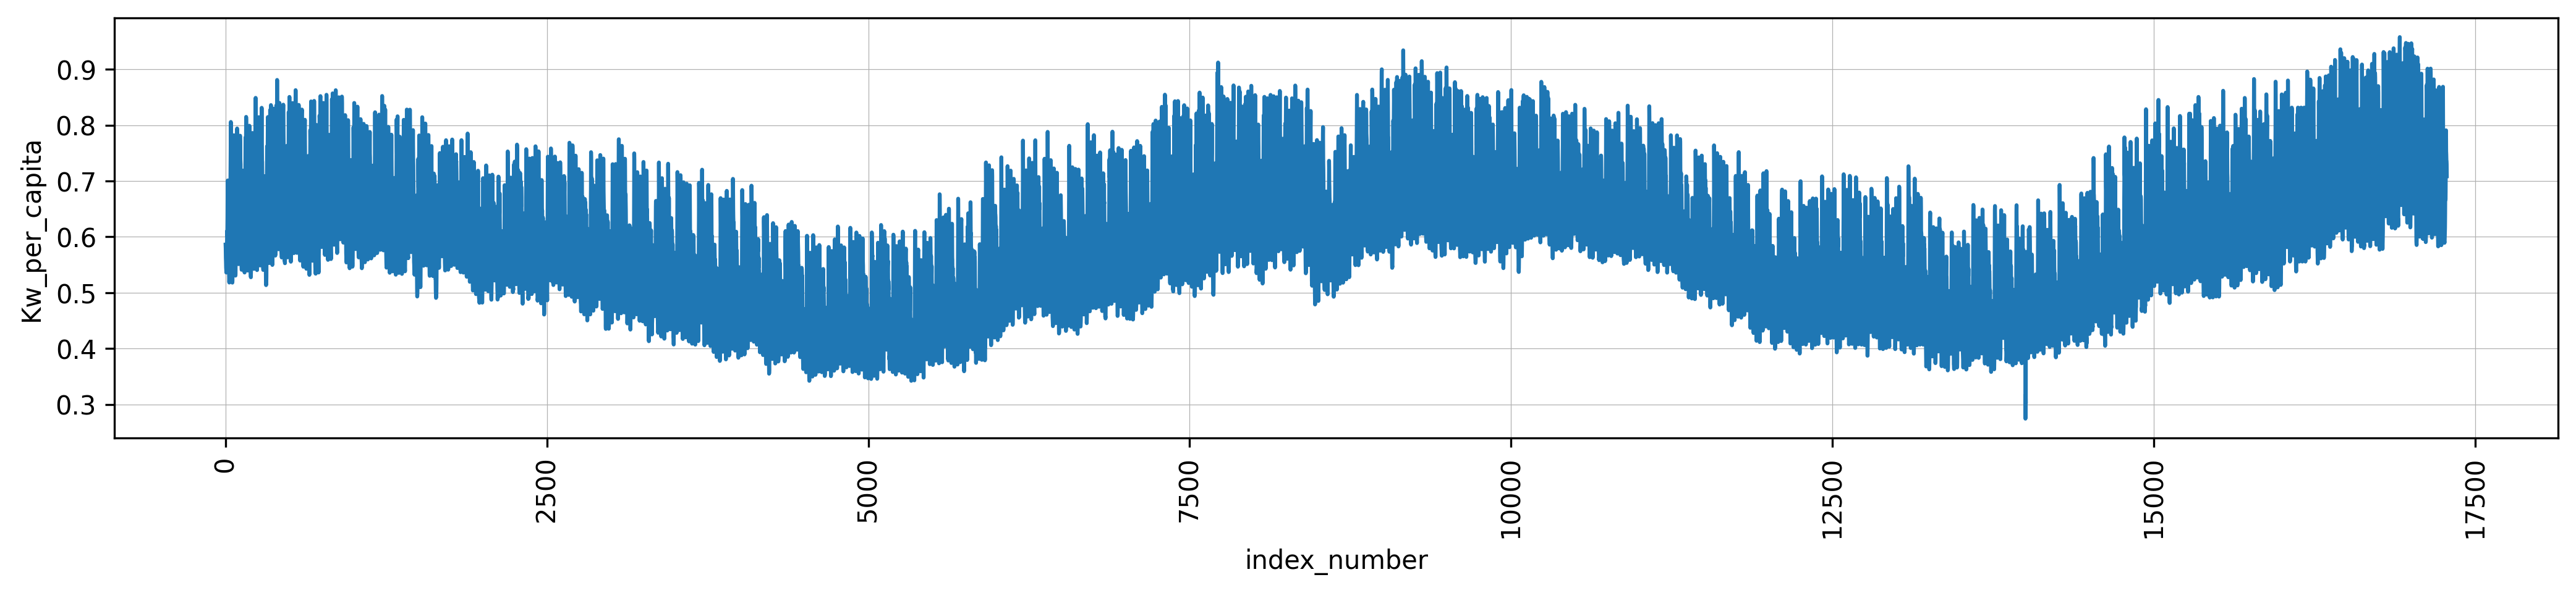

In [84]:
# plot time series
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=df1.head(17280), x= 'index_number', y='Kw_per_capita')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)
# dfc.keys()

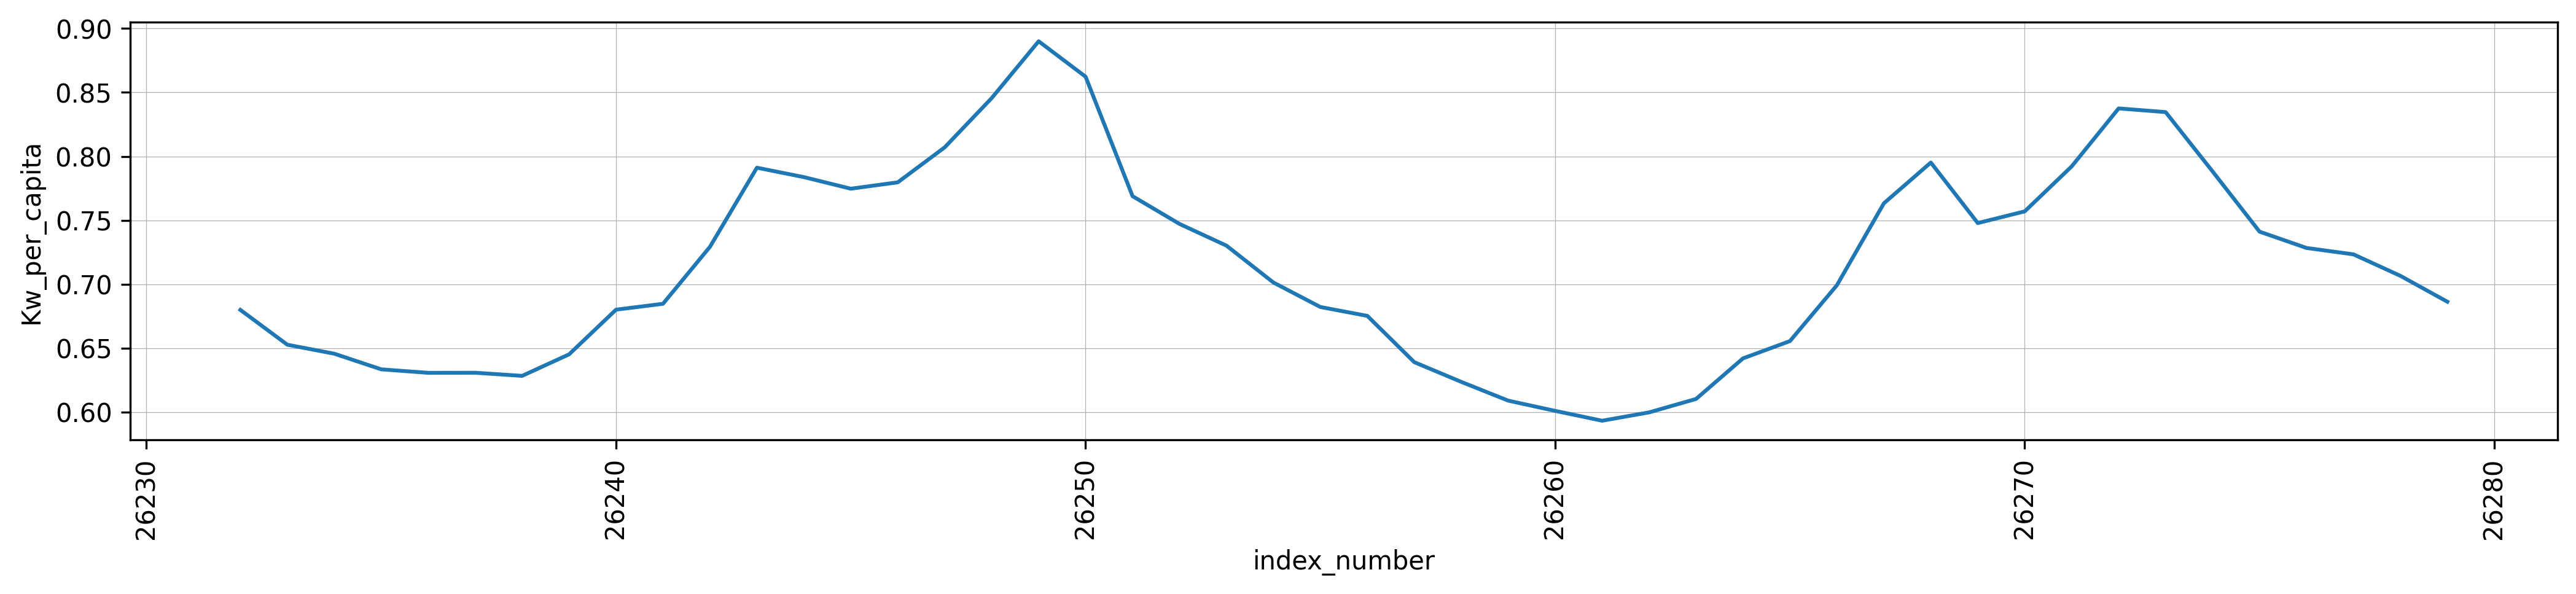

In [85]:
# plot time series
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=df1.tail(48), x= 'index_number', y='Kw_per_capita')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)
# dfc.keys()

In [86]:
# see if there are any missing values
df1.isna().sum()

index            0
hour             0
lat              0
Temp             0
date             0
weekday          0
is_holiday       0
Kw_per_capita    0
index_number     0
dtype: int64

## Feature engineering

In [90]:
df1.tail(2)

,index,hour,lat,Temp,date,weekday,is_holiday,Kw_per_capita,index_number
26278,52558,22,58.45424,-12.765479,2015-12-31,3,False,0.706639,26278
26279,52559,23,58.45424,-12.875342,2015-12-31,3,False,0.686411,26279


In [89]:
# df1['last3h']=df1['Kw_per_capita']
# for i in range(3,len(df1)):
#   s = 0
#   for n in range(i-3,i):
#     s+=df1['Kw_per_capita'][n]
#   df1['last3h'][i]=s 

# df1.head(10)

In [87]:
df1[24:29]

,index,hour,lat,Temp,date,weekday,is_holiday,Kw_per_capita,index_number
24,26304,0,58.45424,-19.384024,2013-01-02,2,False,0.574695,24
25,26305,1,58.45424,-19.444266,2013-01-02,2,False,0.561368,25
26,26306,2,58.45424,-19.418188,2013-01-02,2,False,0.547498,26
27,26307,3,58.45424,-19.286749,2013-01-02,2,False,0.535184,27
28,26308,4,58.45424,-19.303625,2013-01-02,2,False,0.519964,28


In [113]:
# shit the Kw-per_capita column down 
df1_shift24h = df1.copy()
df1_shift24h['Kw_next24hr'] = df1_shift24h['Kw_per_capita'].shift(-24)
df1_shift24h.head()

,index,hour,lat,Temp,date,weekday,is_holiday,Kw_per_capita,index_number,Kw_next24hr
0,26280,0,58.45424,-18.211905,2013-01-01,1,True,0.586101,0,0.574695
1,26281,1,58.45424,-18.678336,2013-01-01,1,True,0.579210,1,0.561368
2,26282,2,58.45424,-18.978430,2013-01-01,1,True,0.562302,2,0.547498
3,26283,3,58.45424,-18.901541,2013-01-01,1,True,0.555865,3,0.535184
4,26284,4,58.45424,-19.094290,2013-01-01,1,True,0.544718,4,0.519964


In [114]:
df1_shift24h[-26:]

,index,hour,lat,Temp,date,weekday,is_holiday,Kw_per_capita,index_number,Kw_next24hr
26254,52534,22,58.45424,-14.490088,2015-12-30,2,False,0.701416,26254,0.706639
26255,52535,23,58.45424,-14.590430,2015-12-30,2,False,0.682282,26255,0.686411
26256,52536,0,58.45424,-14.574316,2015-12-31,3,False,0.675350,26256,NaN
26257,52537,1,58.45424,-14.905859,2015-12-31,3,False,0.639173,26257,NaN
26258,52538,2,58.45424,-15.014258,2015-12-31,3,False,0.623785,26258,NaN
26259,52539,3,58.45424,-15.161230,2015-12-31,3,False,0.609122,26259,NaN
26260,52540,4,58.45424,-15.203711,2015-12-31,3,False,0.601119,26260,NaN
26261,52541,5,58.45424,-15.160010,2015-12-31,3,False,0.593428,26261,NaN
26262,52542,6,58.45424,-15.172949,2015-12-31,3,False,0.599938,26262,NaN
26263,52543,7,58.45424,-15.464697,2015-12-31,3,False,0.610437,26263,NaN


In [115]:
# Remove the last 24 rows of the dataframe

df1_shift24h = df1_shift24h[:len(df1_shift24h)-24]
df1_shift24h.tail()

,index,hour,lat,Temp,date,weekday,is_holiday,Kw_per_capita,index_number,Kw_next24hr
26251,52531,19,58.45424,-15.029150,2015-12-30,2,False,0.768900,26251,0.741177
26252,52532,20,58.45424,-14.900488,2015-12-30,2,False,0.747206,26252,0.728437
26253,52533,21,58.45424,-15.035010,2015-12-30,2,False,0.730232,26253,0.723428
26254,52534,22,58.45424,-14.490088,2015-12-30,2,False,0.701416,26254,0.706639
26255,52535,23,58.45424,-14.590430,2015-12-30,2,False,0.682282,26255,0.686411


In [117]:
# make a copy for later visualization
df1_shift24hr = df1_shift24h.copy()


In [116]:
# count the number of days
# total_days = len(np.unique(df1_shift24h['date']))
# print(total_days)
total_days = len(df1_shift24h)/24
print(total_days)

1094.0


In [95]:
# remove further unnecessary features
df1_shift24h.drop(['index','lat','date','index_number'], axis=1, inplace=True)
df1_shift24h.head()

,hour,Temp,weekday,is_holiday,Kw_per_capita,Kw_next24hr
0,0,-18.211905,1,True,0.586101,0.574695
1,1,-18.678336,1,True,0.579210,0.561368
2,2,-18.978430,1,True,0.562302,0.547498
3,3,-18.901541,1,True,0.555865,0.535184
4,4,-19.094290,1,True,0.544718,0.519964


## Train-test split
**Problems:**
- ***we CAN't randomly split a time series with train_test_split(), because the split will randomly select points of time that appear in our train/test data set, which means the time is not continuous, or create gaps in time, this will disrupt the potential correlation exists in a time series.***
- the best to way to train-test split a time series is just take the early 80% as the train data, the following 20% as test data

In [96]:
# determin the train-test split point

split_day = round(total_days*0.8,0)
print(split_day)
split_hour = split_day * 24
print(split_hour)

875.0
21000.0


In [97]:
# alternative train-test split 
# train_dataset, test_dataset = train_test_split(dfc, test_size=0.2)
train_data = df1_shift24h[:int(split_hour)]
test_data = df1_shift24h[int(split_hour):]

In [98]:
# train_data.sample(2)
test_data.sample(2)

,hour,Temp,weekday,is_holiday,Kw_per_capita,Kw_next24hr
22585,1,13.074854,4,False,0.502424,0.456173
25449,9,-11.809668,4,False,0.814221,0.740678


In [99]:
# create input and output variables datasets
X_train = train_data.copy()
X_test = test_data.copy()

y_train = X_train.pop('Kw_next24hr')
y_test = X_test.pop('Kw_next24hr')

# get the values from the dataframe - the result is a numpy array
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

# TODO: explore if we need to construct a DMatrix as the input to XGBoost

train = train = xgb.DMatrix(X_train, label = y_train)  
test = xgb.DMatrix(X_test, label = y_test)

# Reshape the arrays for the predicted variable
# TODO: is this needed here?
y_train = np.reshape(y_train, (-1,1))
y_test = np.reshape(y_test, (-1,1))

In [ ]:
# X_train = train_data.copy().drop(columns=['date','Kw_per_capita'])
# X_test = test_data.copy().drop(columns=['date','Kw_per_capita'])

# y_train = train_data.copy().pop('Kw_per_capita')
# y_test = test_data.copy().pop('Kw_per_capita')

In [202]:
# X_train.sample(3)
# y_train.sample(3)

In [100]:
# define the MAPE metric
def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [133]:
xgb_r = xgb.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 1000, max_depth=3,  seed = 123, learning_rate=0.05)
  
# Fitting the model
xgb_r.fit(X_train, y_train)

XGBRegressor(learning_rate=0.05, n_estimators=1000,
             objective='reg:squarederror', seed=123)

In [134]:
# Predictions on the train dataset
train_pred = xgb_r.predict(X_train)

# MAE Computation
train_mae = mean_absolute_error(y_train, train_pred)
print("MAE:  % f" %(train_mae))

# RMSE Computation
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
print("RMSE: % f" %(train_rmse))

MAE:   0.019993
RMSE:  0.027792


In [135]:
test_pred = xgb_r.predict(X_test)
  
# MAE Computation
test_mae = mean_absolute_error(y_test, test_pred)
print("MAE:  % f" %(test_mae))

# RMSE Computation
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print("RMSE : % f" %(test_rmse))

MAE:   0.025530
RMSE :  0.037287


In [136]:
# create predictions dataframe for visualization

len(test_pred)

5256

In [137]:
test_index_number = [i for i in range(21000,26256)]
print(len(test_index_number))
test_index_number[-3:]

5256


[26253, 26254, 26255]

In [138]:
predictions_dict = {'predictions':test_pred, 'test_index':test_index_number}
df_predictions = pd.DataFrame(predictions_dict)
df_predictions.tail()

,predictions,test_index
5251,0.765285,26251
5252,0.745026,26252
5253,0.735127,26253
5254,0.699212,26254
5255,0.683341,26255


In [139]:
# Check the means of the datasets to help interpret the RMSE values

print("Average Kw in the training dataset:  ", train_data['Kw_per_capita'].mean())
print("Average Kw in the test dataset:      ", test_data['Kw_per_capita'].mean())

Average Kw in the training dataset:   0.6322073747710166
Average Kw in the test dataset:       0.6285856968245425


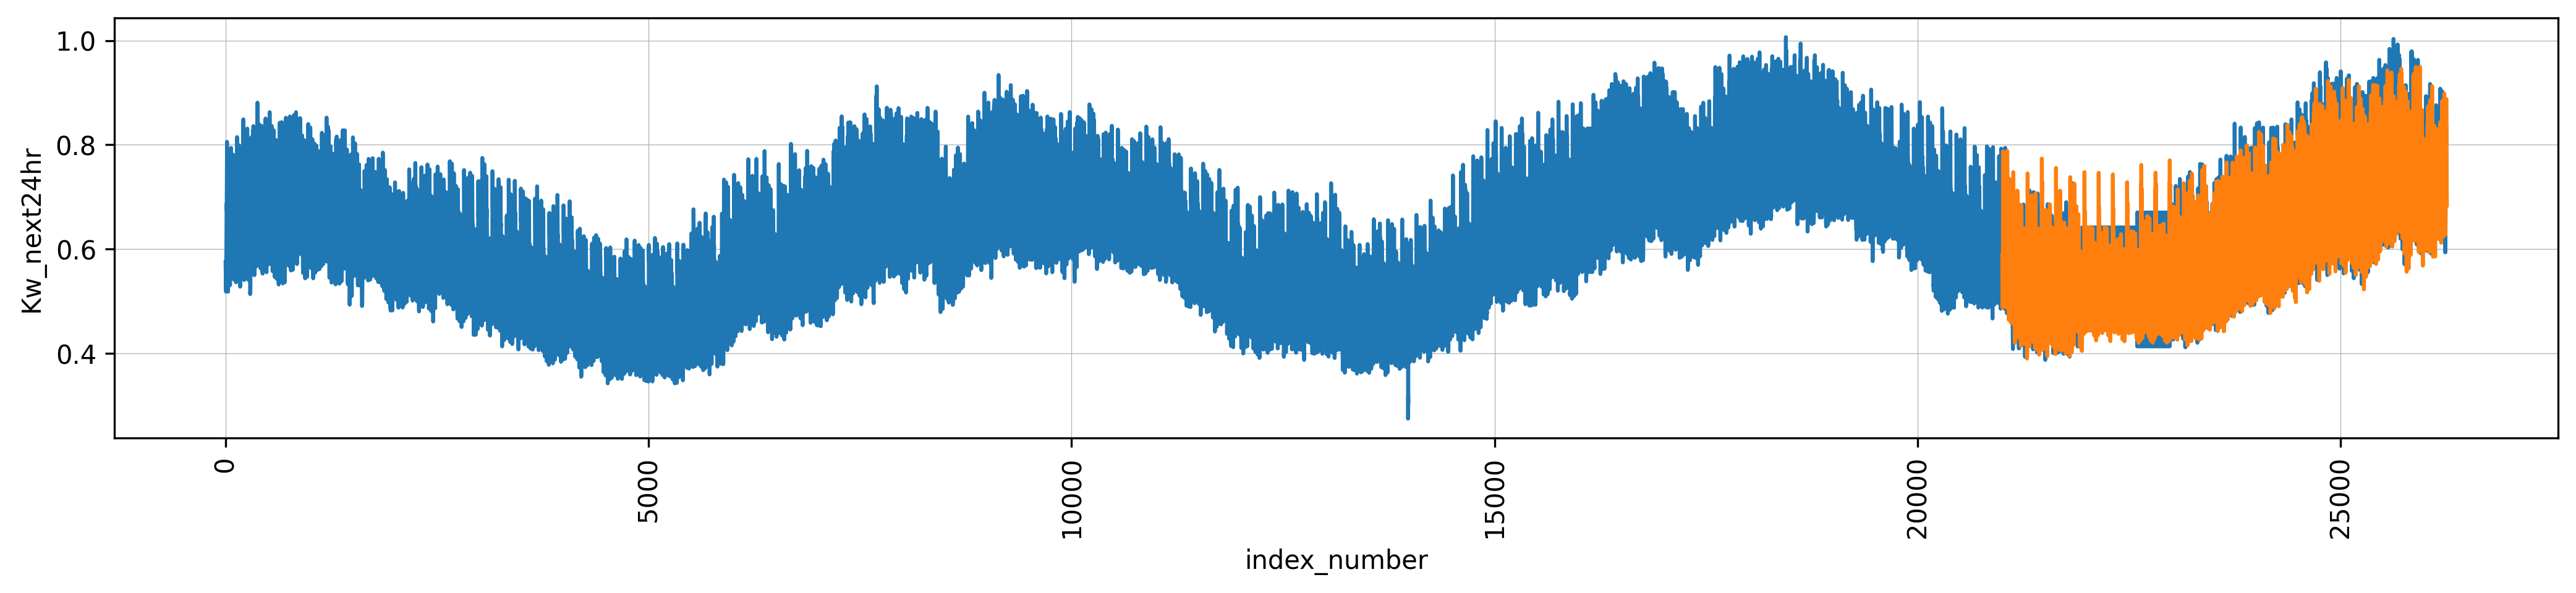

In [140]:
# plot time series
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=df1_shift24hr, x='index_number', y='Kw_next24hr')
sns.lineplot(data=df_predictions, x= 'test_index', y='predictions')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)
# dfc.keys()